## Librerias

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

Carga de imagenes

# **PASO 1: Adquisición de Imagenes**

--2024-09-30 03:03:27--  https://docs.google.com/uc?export=download&id=1JmBUJ1kuOduj2lQqvZKFOGfhc8TFVust
Resolving docs.google.com (docs.google.com)... 64.233.186.100, 64.233.186.101, 64.233.186.139, ...
Connecting to docs.google.com (docs.google.com)|64.233.186.100|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JmBUJ1kuOduj2lQqvZKFOGfhc8TFVust&export=download [following]
--2024-09-30 03:03:27--  https://drive.usercontent.google.com/download?id=1JmBUJ1kuOduj2lQqvZKFOGfhc8TFVust&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 64.233.186.132
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|64.233.186.132|:443... connected.
  Self-signed certificate encountered.
HTTP request sent, awaiting response... 200 OK
Length: 2008697 (1.9M) [image/jpeg]
Saving to: ‘foto1.jpg’

foto1.jpg           100%[=========

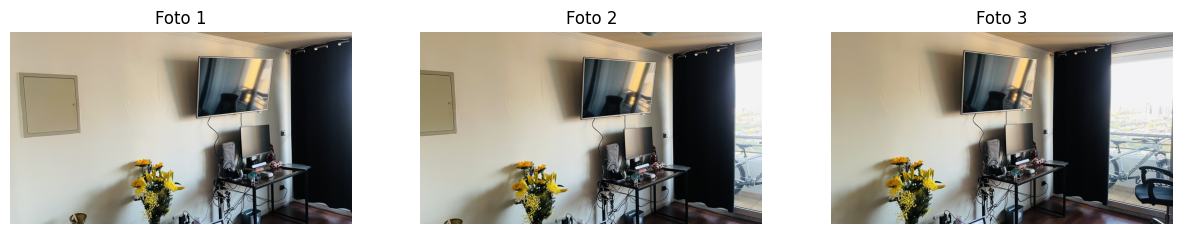

In [100]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JmBUJ1kuOduj2lQqvZKFOGfhc8TFVust' -O foto1.jpg
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qDFfdouGJ-nDpZ6BkpPgY_DCzkcHUlWp' -O foto2.jpg
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1t4CSDMSgodj0wukJqDsgcsQXYItnVl6z' -O foto3.jpg

I1 = cv2.imread("foto1.jpg")
I2 = cv2.imread("foto2.jpg")
I3 = cv2.imread("foto3.jpg")

I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)
I3 = cv2.cvtColor(I3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(I1)
plt.title("Foto 1")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(I2)
plt.title("Foto 2")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(I3)
plt.title("Foto 3")
plt.axis('off')

plt.show()


Puntos correspondientes fotos 2D

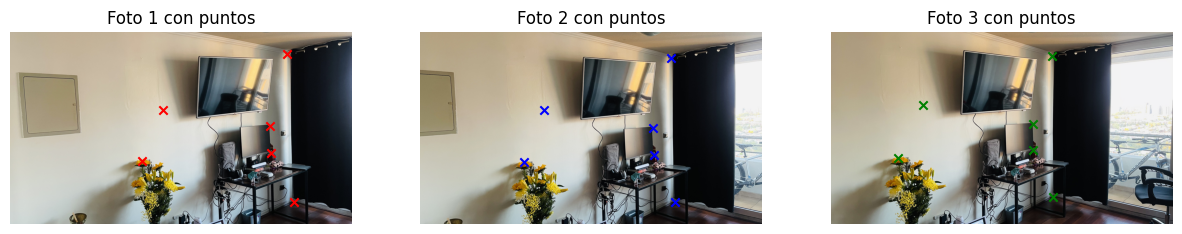

In [101]:
# foto 1

xp1 = [3344, 3271, 3060, 3078, 1802, 1555]
yp1 = [2011, 263, 1106, 1427, 924, 1522]

xp2 = [3001, 2958, 2742, 2753, 1461, 1217]
yp2 = [2011, 307, 1139, 1449, 920, 1540]

xp3 = [2625, 2613, 2381, 2387, 1094, 794]
yp3 = [1952, 288, 1091, 1394, 859, 1492]

I1 = cv2.imread("foto1.jpg")
I2 = cv2.imread("foto2.jpg")
I3 = cv2.imread("foto3.jpg")

I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)
I3 = cv2.cvtColor(I3, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.imshow(I1)
plt.scatter(xp1, yp1, c='red', marker='x')
plt.title('Foto 1 con puntos')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(I2)
plt.scatter(xp2, yp2, c='blue', marker='x')
plt.title('Foto 2 con puntos')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(I3)
plt.scatter(xp3, yp3, c='green', marker='x')
plt.title('Foto 3 con puntos')
plt.axis('off')

plt.show()

# **PASO 2: Homografías entre las imágenes**

Funciones para encontrar homografias

In [129]:
def homography_matrix(m,mp):
  (x ,y ) = m
  (xp,yp) = mp
  n       = len(x)
  A       = np.zeros((2*n,9))
  for i in range(n):
    j = i*2
    A[j  ,:] = [x[i], y[i], 1,     0,     0, 0, -x[i]*xp[i], -y[i]*xp[i], -xp[i]]
    A[j+1,:] = [  0  ,   0  , 0, x[i], y[i], 1, -x[i]*yp[i], -y[i]*yp[i], -yp[i]]
  [U,S,V] = np.linalg.svd(A)
  h       = V[-1,:]
  H       = np.vstack([h[0:3], h[3:6], h[6:9]])
  return H

def _homography(X,H, N, M):
  Hinv  = np.linalg.inv(H)
  Xp    = np.zeros((N,M),np.uint8)

  m = np.ones((N*M,3))
  t = 0
  for i in range(N):
    for j in range(M):
      m[t,0:2] = [j,i]
      t = t+1

  mph = np.dot(Hinv,m.T)  # Transformation m to mp
  mp  = np.divide(mph[0:2,:],mph[2,:])
  mpf = np.fix(mp).astype(int)

  ip = mpf[1,:]
  jp = mpf[0,:]
  ktj = np.logical_and(jp>=0,jp<M)
  kti = np.logical_and(ip>=0,ip<N)
  kt  = np.logical_and(kti,ktj)

  t = 0
  for i in range(N):
    for j in range(M):
      if kt[t]:
        Xp[i,j] = X[ip[t],jp[t]]
      t = t+1
  return Xp

def homography(X, H, N, M, invert=False):
   
    if invert:
        H = np.linalg.inv(H)
    if len(X.shape) == 2:
        channels = 1
    else:
        channels = X.shape[2]
    Xp = np.zeros((N, M, channels), dtype=X.dtype)

    m = np.ones((N * M, 3))
    t = 0
    for i in range(N):
        for j in range(M):
            m[t, 0:2] = [j, i]
            t += 1

    mph = np.dot(H, m.T)
    mp = np.divide(mph[0:2, :], mph[2, :])
    mpf = np.fix(mp).astype(int)

    ip = mpf[1, :]
    jp = mpf[0, :]
    valid_j = np.logical_and(jp >= 0, jp < X.shape[1])
    valid_i = np.logical_and(ip >= 0, ip < X.shape[0])
    valid = np.logical_and(valid_i, valid_j)

    t = 0
    for i in range(N):
        for j in range(M):
            if valid[t]:
                if channels == 1:
                    Xp[i, j] = X[ip[t], jp[t]]
                else:
                    Xp[i, j, :] = X[ip[t], jp[t], :]
            t += 1

    if channels == 1:
        Xp = Xp.reshape(N, M)
    return Xp


## Homografia entre Foto 1 y Foto 2

mp  =  ([3344, 3271, 3060, 3078, 1802, 1555], [2011, 263, 1106, 1427, 924, 1522])
m   =  ([3001, 2958, 2742, 2753, 1461, 1217], [2011, 307, 1139, 1449, 920, 1540])
Estimacion de mp a partir de m:
mps =  (array([3345.65773038, 3273.67949347, 3059.47237636, 3073.9122287 ,
       1799.25507893, 1558.13839672]), array([2013.37652501,  265.41589428, 1105.4406151 , 1422.36479941,
        922.12167982, 1524.31287434]))
Imagen izquierda: Transformada                       | Imagen derecha: Original


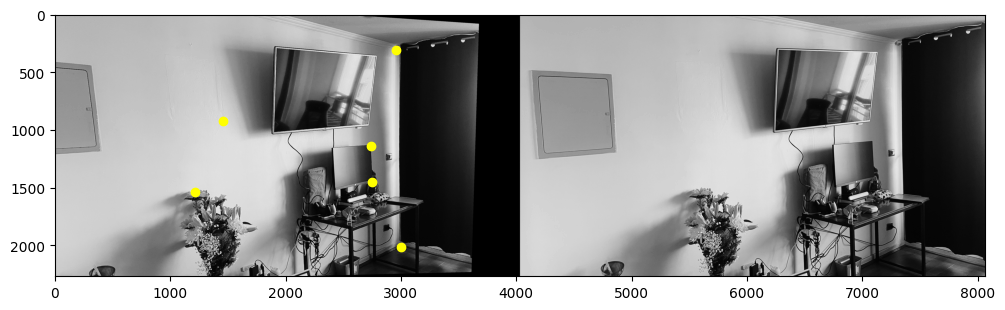

In [130]:
I1 = cv2.imread("foto1.jpg", 0)
(N1,M1) = I1.shape
print('mp  = ', (xp1,yp1))
print('m   = ', (xp2,yp2))

mm = np.vstack([xp2, yp2, np.array([1, 1, 1, 1, 1, 1])])
H2 = homography_matrix((xp2,yp2),(xp1,yp1))
mmp = np.dot(H2,mm)
mmp = mmp/mmp[-1,:]

print('Estimacion de mp a partir de m:')
print('mps = ', (mmp[0,:],mmp[1,:]))
Hinv  = np.linalg.inv(H2)

Y = _homography(I1,Hinv, N1, M1)
Z = np.concatenate((Y,I1),axis=1)

print('Imagen izquierda: Transformada                       | Imagen derecha: Original')
plt.figure(figsize=(12,12))
plt.imshow(Z,cmap='gray')
plt.scatter(xp2,yp2,c='yellow')
plt.show()

## Homografia entre foto2 y foto3

mp  =  ([3001, 2958, 2742, 2753, 1461, 1217], [2011, 307, 1139, 1449, 920, 1540])
m   =  ([2625, 2613, 2381, 2387, 1094, 794], [1952, 288, 1091, 1394, 859, 1492])
Estimacion de mp a partir de m:
mps =  (array([3004.03294996, 2958.70724038, 2738.21097981, 2751.65804121,
       1464.78097961, 1214.75927378]), array([2009.19019917,  305.09215682, 1142.73574702, 1449.51752274,
        919.85949339, 1539.63652123]))
Imagen izquierda: Transformada                       | Imagen derecha: Original


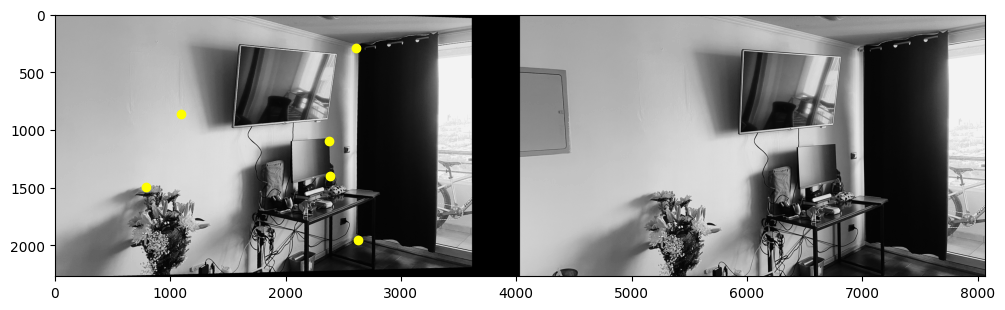

In [131]:
I2 = cv2.imread("foto2.jpg", 0)
(N2,M2) = I2.shape
print('mp  = ', (xp2,yp2))
print('m   = ', (xp3,yp3))

mm = np.vstack([xp3, yp3, np.array([1, 1, 1, 1, 1, 1])])
H2 = homography_matrix((xp3,yp3),(xp2,yp2))
mmp = np.dot(H2,mm)
mmp = mmp/mmp[-1,:]

print('Estimacion de mp a partir de m:')
print('mps = ', (mmp[0,:],mmp[1,:]))
Hinv  = np.linalg.inv(H2)

Y = _homography(I2,Hinv, N2, M2)
Z = np.concatenate((Y,I2),axis=1)

print('Imagen izquierda: Transformada                       | Imagen derecha: Original')
plt.figure(figsize=(12,12))
plt.imshow(Z,cmap='gray')
plt.scatter(xp3,yp3,c='yellow')
plt.show()

# **PASO 3: Calibración de cada cámara**

## Calibracion *foto1*

In [132]:
def calibra_solucion_2(M,w):

  n = M.shape[1]

  for i in range(n):
    X   = M[0,i]
    Y   = M[1,i]
    Z   = M[2,i]
    u   = w[0,i]
    v   = w[1,i]
    x1  = np.array([X,Y,Z,1,0,0,0,0,-u*X,-u*Y,-u*Z,-u])
    x2  = np.array([0,0,0,0,X,Y,Z,1,-v*X,-v*Y,-v*Z,-v])
    XXi = np.vstack([x1,x2])
    if i==0:
      XX = XXi
    else:
      XX = np.vstack([XX,XXi])

  [U,S,V] = np.linalg.svd(XX)
  a       = V[-1,:]


  # Matriz de proyección estimada
  P  = np.array([
          [a[0], a[1], a[2], a[3]],
          [a[4], a[5], a[6], a[7]],
          [a[8], a[9], a[10], a[11]]
  ])
  return P

Text(0.5, 1.0, 'Foto 1 con puntos u3 y v3')

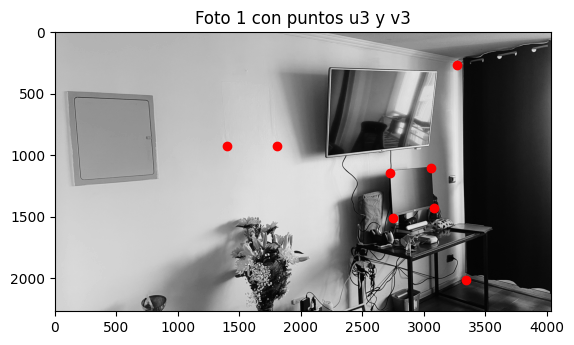

In [133]:
#Puntos 2D Foto 1 (x, y)
u1 = np.array([3344, 3271, 3060, 3078, 2720, 2747, 1802, 1397])
v1 = np.array([2011, 263, 1106, 1427, 1141, 1507, 924, 924])
o1 = np.ones((1,len(u1)))
w1 = np.vstack([u1,v1,o1])

plt.imshow(I1,cmap='gray')
plt.scatter(u1,v1,c='red')
plt.title("Foto 1 con puntos u3 y v3")

In [134]:
# foto 1 (x, y, z)

p0 = np.array([0, 0, 0, 1]).reshape(4, 1)
p1 = np.array([0, 0, 2.27, 1]).reshape(4, 1)

p2 = np.array([0.65, 0.15, 1.28,1]).reshape(4, 1)
p3 = np.array([0.65, 0.18, 0.92,1]).reshape(4, 1)

p4 = np.array([1.26,0.18,1.295,1]).reshape(4, 1)
p5 = np.array([1.26, 0.2, 0.93,1]).reshape(4, 1)

p6 = np.array([2.2, 0, 1.55,1]).reshape(4, 1)
p7 = np.array([2.57, 0, 1.55,1]).reshape(4, 1)

M = np.hstack([p0,p1,p2,p3,p4,p5,p6,p7])
M


array([[0.   , 0.   , 0.65 , 0.65 , 1.26 , 1.26 , 2.2  , 2.57 ],
       [0.   , 0.   , 0.15 , 0.18 , 0.18 , 0.2  , 0.   , 0.   ],
       [0.   , 2.27 , 1.28 , 0.92 , 1.295, 0.93 , 1.55 , 1.55 ],
       [1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ]])

Funciones para calibrar las cámaras

In [135]:
P1 = calibra_solucion_2(M,w1)

Text(0.5, 1.0, 'Foto 1 calibrada')

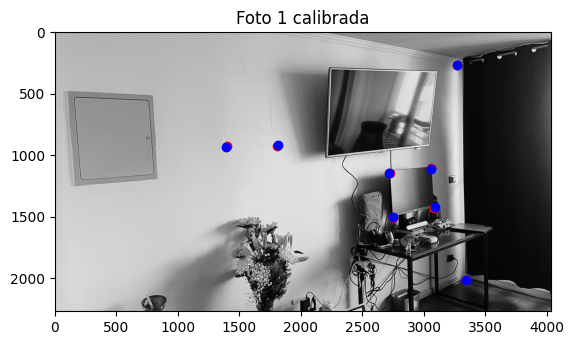

In [136]:
plt.imshow(I1,cmap='gray')
plt.scatter(w1[0,:],w1[1,:],c='red')

ws = np.dot(P1,M)
ws = ws/ws[-1]
plt.scatter(ws[0,:],ws[1,:],c='blue')

plt.title("Foto 1 calibrada")

## Calibracion *foto2*

Text(0.5, 1.0, 'Foto 2 con puntos u3 y v3')

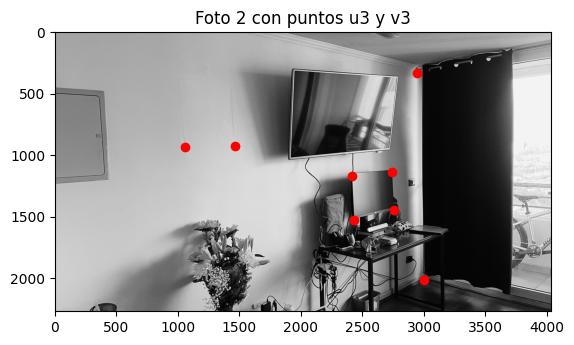

In [137]:
#Puntos 2D Foto 2 (x, y)
u2 = np.array([3002, 2943, 2738, 2753, 2414, 2435, 1468, 1061])
v2 = np.array([2015, 327, 1135, 1444, 1165, 1527, 924, 930])

o2 = np.ones((1,len(u2)))
w2 = np.vstack([u2,v2,o2])

plt.imshow(I2,cmap='gray')
plt.scatter(u2,v2,c='red')
plt.title("Foto 2 con puntos u3 y v3")

In [138]:
P2 = calibra_solucion_2(M,w2)

Text(0.5, 1.0, 'Foto 2 calibrada')

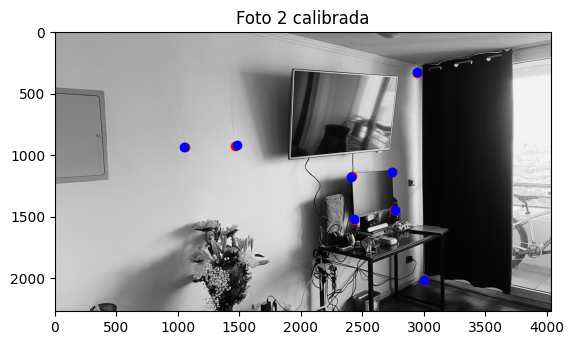

In [139]:
plt.imshow(I2,cmap='gray')
plt.scatter(w2[0,:],w2[1,:],c='red')

ws = np.dot(P2,M)
ws = ws/ws[-1]
plt.scatter(ws[0,:],ws[1,:],c='blue')

plt.title("Foto 2 calibrada")

## Calibracion *foto3*

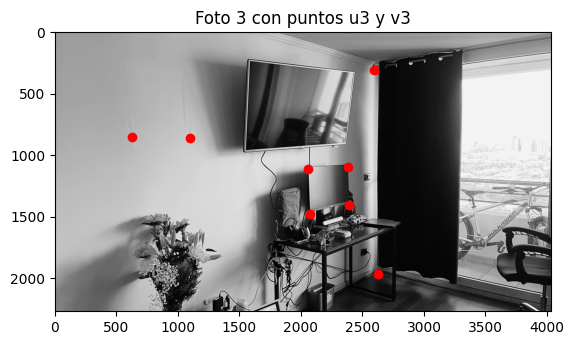

In [140]:
#Puntos 2D Foto 3 (x, y)
u3 = np.array([2628, 2592, 2381, 2390, 2057, 2075, 1097, 627])
v3 = np.array([1964, 306, 1091, 1400, 1111, 1474, 859, 850])


o3 = np.ones((1, len(u3)))
w3 = np.vstack([u3, v3, o3])

plt.imshow(I3, cmap='gray')
plt.scatter(u3, v3, c='red')
plt.title("Foto 3 con puntos u3 y v3")
plt.show()

In [141]:
P3 = calibra_solucion_2(M,w3)

Text(0.5, 1.0, 'Foto 3 calibrada')

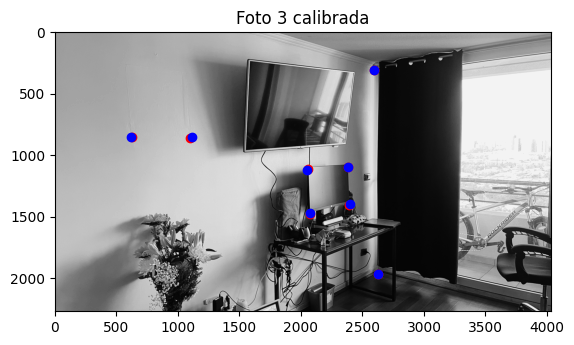

In [142]:
plt.imshow(I3,cmap='gray')
plt.scatter(w3[0,:],w3[1,:],c='red')

ws = np.dot(P3,M)
ws = ws/ws[-1]
plt.scatter(ws[0,:],ws[1,:],c='blue')

plt.title("Foto 3 calibrada")

# **PASO 4: Geometría Epipolar**

## Funciones necesarias para Geometría Epipolar

In [143]:
def plot_epipolar_line(mat_f, m, ax, line_color='r'):
    """
    This method plot an epipolar line into an open figure.

    Args:
        mat_f: numpy array with the fundamental matrix
        m: numpy array with a image point (2D)
        ax: a matplotlib figure axe
        line_color: an string indicating the line color

    Returns:
        ax: the figure axe

    """
    if m.shape[-1] == 2:
        m = np.hstack([m, np.ones((m.shape[0], 1))])

    ell = np.dot(mat_f, m)
    ell = ell / ell[-1]
    ax_lim = ax.axis()
    x = np.asarray(ax_lim[0:2])
    a = ell[0]
    b = ell[1]
    c = ell[2]

    y = -(c + a * x) / b

    ax.plot(x, y, line_color)
    ax.axis('off')


def plot_epipolar_line_limited(mat_f, m, ax, img_shape, line_color='r'):
    """
    This method plots an epipolar line that is limited to the image bounds and highlights intersection points.

    Args:
        mat_f: numpy array with the fundamental matrix
        m: numpy array with an image point (2D)
        ax: a matplotlib figure axis
        img_shape: shape of the image to limit the epipolar line (height, width)
        line_color: a string indicating the line color

    Returns:
        ax: the figure axis with the line and intersection points drawn
    """
    if m.shape[-1] == 2:
        # Convert the 2D point to homogeneous coordinates as a column vector (3x1)
        m = np.hstack([m, np.ones((m.shape[0], 1))]).T  # Transpose to make it (3x1)

    # Compute the epipolar line as a 3x1 vector (dot product of F and m)
    ell = np.dot(mat_f, m)
    ell = ell.flatten()  # Flatten to get it as a 1D array

    height, width = img_shape[:2]
    x_min, x_max = 0, width
    y_min, y_max = 0, height

    # Calculate intersection with the borders of the image
    # Intersection with the left and right borders (x = 0 and x = width)
    x_vals = np.array([x_min, x_max])
    y_vals = -(ell[2] + ell[0] * x_vals) / ell[1]

    # Intersection with the top and bottom borders (y = 0 and y = height)
    y_edges = np.array([y_min, y_max])
    x_edges = -(ell[2] + ell[1] * y_edges) / ell[0]

    # Combine all valid points that fall within the image bounds
    valid_x = np.concatenate([x_vals[(y_vals >= y_min) & (y_vals <= y_max)], x_edges[(x_edges >= x_min) & (x_edges <= x_max)]])
    valid_y = np.concatenate([y_vals[(y_vals >= y_min) & (y_vals <= y_max)], y_edges[(x_edges >= x_min) & (x_edges <= x_max)]])

    # Ensure that at least one point is valid for plotting
    if len(valid_x) > 1 and len(valid_y) > 1:
        ax.plot(valid_x, valid_y, line_color)

        return ell
    else:
        print("No valid points to plot the epipolar line within the image bounds.")
        return None, None


def estimate_fundamental_matrix(mat_a, mat_b, method='pseudo'):
    """
    This method computes the 3x3 fundamental matrix from 3x4 projection matrices A and B according methods defined in
    method parameter. We refer the reader to [1] for more details about this implementation.

    Args:
        mat_a: numpy array with projection matrix of view 1
        mat_b: numpy array with projection matrix of view 2
        method: a string defining computation method. If no method is given,
            'pseudo' will be assumed as default.
            'tensor' : uses bifocal tensors with canonic matrix
            'tensor0': uses bifocal tensors without canonic matrix
            'pseudo' : uses pseudoinverse matrix of A (default)

    Returns:
        mat_f: the 3x3 fundamental matrix.

    [1] R. Hartley and A. Zisserman. Multiple View Geometry in Computer Vision.
    Cambridge University Press, 2000.
    """

    if method.lower() == 'tensor':
        mat_h = np.vstack([mat_a, np.random.rand(4)])

        while np.abs(np.linalg.det(mat_h)) < 0.001:
            mat_h = np.vstack([mat_a, np.random.rand(4)])

        mat_bs = np.dot(mat_b, np.linalg.inv(mat_h))
        b = np.vstack([mat_bs, mat_bs])

        mat_f = np.zeros((3, 3))

        for i in range(3):
            for j in range(3):
                mat_f[i, j] = b[i + 1, j] * b[i + 2, 3] - b[i + 2, j] * b[
                    i + 1, 3]

    elif method.lower() == 'tensor0':
        # TODO: Verificar con Domingo
        mat_f = np.zeros((3, 3))

        for i in range(3):
            sb = mat_b.copy()
            sb = np.delete(sb, i, 0)

            for j in range(3):
                sa = mat_a.copy()
                sa = np.delete(sa, j, 0)

                mat_f[i][j] = (-1) ** (i + j) * np.linalg.det(
                    np.vstack([sa, sb]))

    else:
        # Find mat_c1 as the null space of the projection matrix using SVD factorization of mat_a. The null vector is
        # the last row in the matrix V.T . See numpy documentation for more details.

        _, _, mat_v = np.linalg.svd(mat_a)
        mat_c1 = mat_v[-1, :].reshape(-1, 1)
        mat_u = skew_symmetric(mat_b, mat_c1)

        # Compute the fundamental matrix
        mat_f = np.asmatrix(mat_u) * np.asmatrix(mat_b) * np.asmatrix(
            np.linalg.pinv(mat_a))
        mat_f = np.array(mat_f)

    # mat_f = np.array(mat_f / np.linalg.norm(mat_f)[0])  # Normalize as F / norm(F)

    return mat_f

def skew_symmetric(mat, null_space):
    """
    Compute the skew-symmetric matrix.

    :param mat: numpy array with a projection matrix (3x4)
    :param null_space: an array with the null space
    :return: an array with the skew-symmetric matrix.

    """
    # epipole in second view
    e2 = np.dot(mat, null_space)


    # The vector e2 as Skew-symmetric matrix
    mat_u = np.array(
        [[0, -e2[2][0], e2[1][0]],
         [e2[2][0], 0, -e2[0][0]],
         [-e2[1][0], e2[0][0], 0]])

    return mat_u



def find_intersection(line1, line2):
    """
    This function calculates the intersection point of two epipolar lines.

    Args:
        line1: Coefficients of the first line (A1, B1, C1)
        line2: Coefficients of the second line (A2, B2, C2)

    Returns:
        x, y: Coordinates of the intersection point
    """
    A = np.array([[line1[0], line1[1]],
                  [line2[0], line2[1]]])
    b = -np.array([line1[2], line2[2]])

    if np.linalg.det(A) != 0:
        intersection = np.linalg.solve(A, b)
        return intersection[0], intersection[1]
    else:
        print("The lines are parallel or coincident.")
        return None, None

## Esquinas correspondientes en la imagen 3

Matriz Fundamental F13 estimada:
 [[ 5.02608311e-07  4.84327317e-06 -1.69442520e-03]
 [-4.81240068e-06  1.06292570e-07  1.37801454e-02]
 [-7.79558898e-04 -1.07537779e-02  2.79853587e+00]]
Matriz Fundamental F23 estimada:
 [[ 1.11088597e-06 -1.65433643e-05  4.04680912e-02]
 [ 1.53931327e-05 -4.59694002e-07 -5.62289743e-02]
 [-4.28509307e-02  5.47870875e-02  1.22254295e+01]]


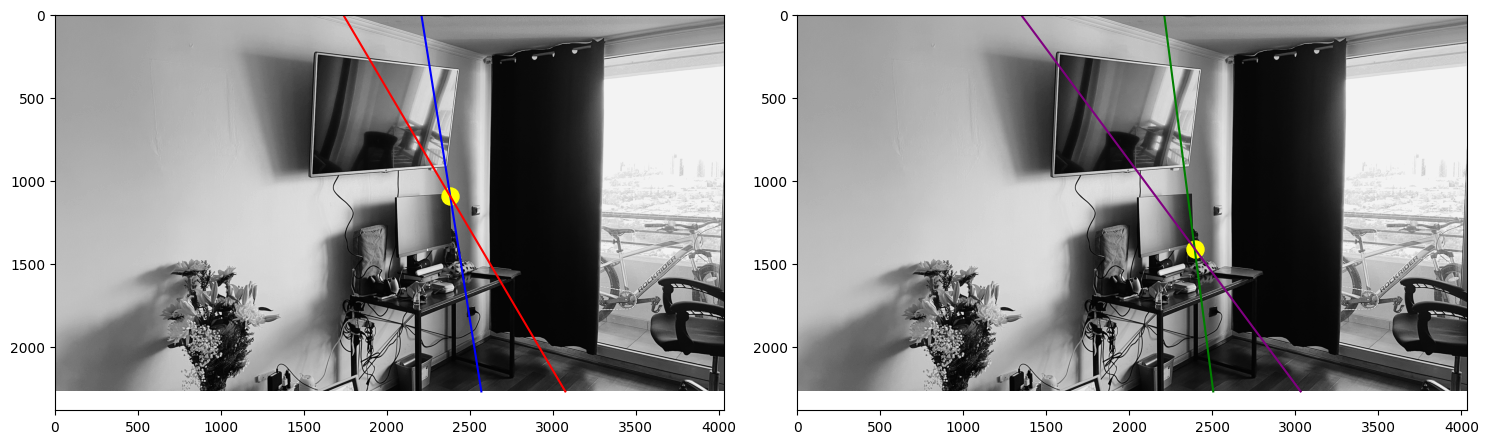

In [144]:
I1 = cv2.imread("foto1.jpg", 0)
I2 = cv2.imread("foto2.jpg", 0)
I3 = cv2.imread("foto3.jpg", 0)

tv_corners_1 = np.array([[3060, 1106], [3078, 1427]])

tv_corners_2 = np.array([[2742, 1139], [2753, 1449]])

F13 = estimate_fundamental_matrix(P1, P3)
print("Matriz Fundamental F13 estimada:\n", F13)

F23 = estimate_fundamental_matrix(P2, P3)
print("Matriz Fundamental F23 estimada:\n", F23)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(I3, cmap='gray')
ell1 = plot_epipolar_line_limited(F13, np.array([tv_corners_1[0]]), axes[0], I3.shape, line_color='blue')
ell2 = plot_epipolar_line_limited(F23, np.array([tv_corners_2[0]]), axes[0], I3.shape, line_color='red')
x_int1, y_int1 = find_intersection(ell1, ell2)
if x_int1 and y_int1:
    axes[0].scatter(x_int1, y_int1, color='yellow', s=150)


axes[1].imshow(I3, cmap='gray')
ell3 = plot_epipolar_line_limited(F13, np.array([tv_corners_1[1]]), axes[1], I3.shape, line_color='green')
ell4 = plot_epipolar_line_limited(F23, np.array([tv_corners_2[1]]), axes[1], I3.shape, line_color='purple')
x_int2, y_int2 = find_intersection(ell3, ell4)
if x_int1 and y_int1:
    axes[1].scatter(x_int2, y_int2, color='yellow', s=150)


plt.tight_layout()
plt.show()

# **PASO 6: Reconstrucción 3D**

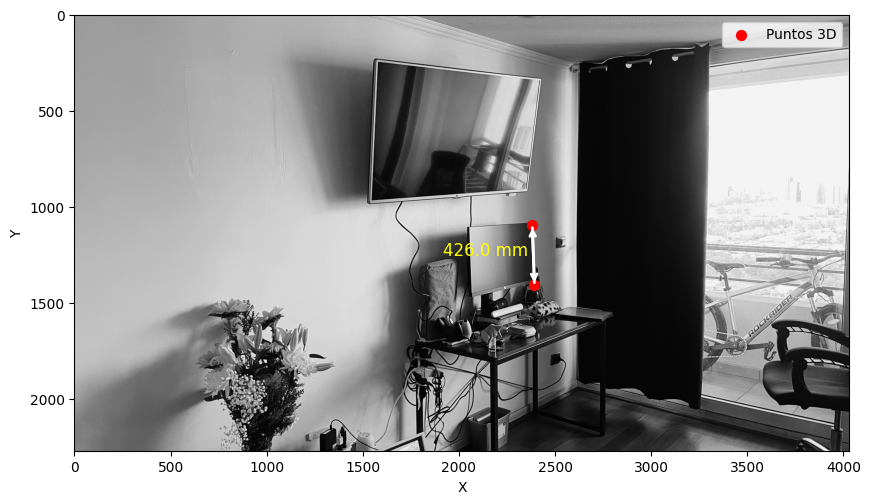

In [145]:
point_sup_der_2d = np.array([x_int1, y_int1])
point_inf_der_2d = np.array([x_int2, y_int2])

point_2d_h_sup = np.array([point_sup_der_2d[0], point_sup_der_2d[1], 1])
point_2d_h_inf = np.array([point_inf_der_2d[0], point_inf_der_2d[1], 1])

P_inv = np.linalg.pinv(P3)

point_3D_sup_h = np.dot(P_inv, point_2d_h_sup)
point_3D_inf_h = np.dot(P_inv, point_2d_h_inf)

point_3D_sup = point_3D_sup_h[:3] / point_3D_sup_h[3]
point_3D_inf = point_3D_inf_h[:3] / point_3D_inf_h[3]

distancia_3D = round(np.linalg.norm(point_3D_sup - point_3D_inf) * 1000, 0)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(I3, cmap='gray')
ax.scatter([x_int1, x_int2], [y_int1, y_int2], c='red', s=50, label='Puntos 3D')

arrowprops = dict(arrowstyle='->', linewidth=2, color='white')

ax.annotate('', xy=(x_int2, y_int2), xytext=(x_int1, y_int1),
            arrowprops=arrowprops)

ax.annotate('', xy=(x_int1, y_int1), xytext=(x_int2, y_int2),
            arrowprops=arrowprops)

mid_x = (x_int1 + x_int2) / 2
mid_y = (y_int1 + y_int2) / 2

ax.text(mid_x - 250, mid_y, f"{distancia_3D} mm", fontsize=12, color='yellow', ha='center')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

plt.show()


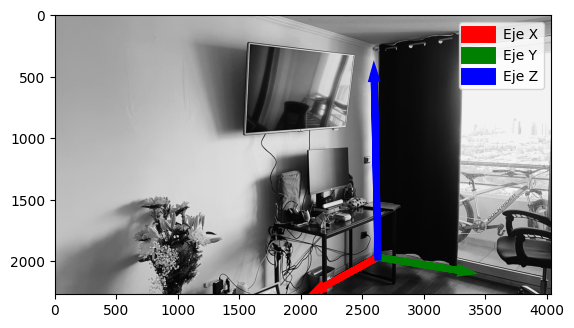

In [146]:
x_axis_world = np.array([[0, 0, 0, 1], [1, 0, 0, 1]]).T
y_axis_world = np.array([[0, 0, 0, 1], [0, 2, 0, 1]]).T
z_axis_world = np.array([[0, 0, 0, 1], [0, 0, 2, 1]]).T

x_axis_proj = np.dot(P3, x_axis_world)
x_axis_proj = x_axis_proj / x_axis_proj[2]

y_axis_proj = np.dot(P3, y_axis_world)
y_axis_proj = y_axis_proj / y_axis_proj[2]

z_axis_proj = np.dot(P3, z_axis_world)
z_axis_proj = z_axis_proj / z_axis_proj[2]

plt.imshow(I3, cmap='gray')

plt.arrow(x_axis_proj[0, 0], x_axis_proj[1, 0],
          x_axis_proj[0, 1] - x_axis_proj[0, 0],
          x_axis_proj[1, 1] - x_axis_proj[1, 0],
          head_width=30, head_length=50, fc='red', ec='red', linewidth=5, label='Eje X')

plt.arrow(y_axis_proj[0, 0], y_axis_proj[1, 0],
          y_axis_proj[0, 1] - y_axis_proj[0, 0],
          y_axis_proj[1, 1] - y_axis_proj[1, 0],
          head_width=30, head_length=50, fc='green', ec='green', linewidth=5, label='Eje Y')

plt.arrow(z_axis_proj[0, 0], z_axis_proj[1, 0],
          z_axis_proj[0, 1] - z_axis_proj[0, 0],
          z_axis_proj[1, 1] - z_axis_proj[1, 0],
          head_width=30, head_length=50, fc='blue', ec='blue', linewidth=5, label='Eje Z')

plt.legend()
plt.show()


# Paso 7: Creación de objeto virtual

## Proyección esfera sobre las 3 fotos

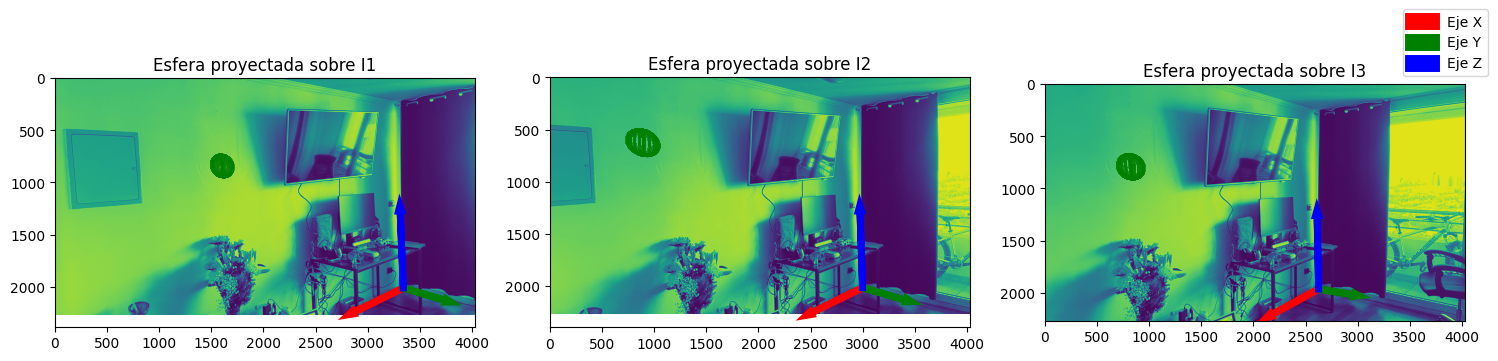

In [147]:
radius = 0.1
u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
x = radius * np.outer(np.cos(u), np.sin(v))
y = radius * np.outer(np.sin(u), np.sin(v))
z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

sphere_points = np.vstack((x.flatten(), y.flatten(), z.flatten(), np.ones(x.size)))

offset_x = 1.9
offset_y = -1
offset_z = 1.5

sphere_points[0, :] += offset_x
sphere_points[1, :] += offset_y
sphere_points[2, :] += offset_z

projected_points_I1 = P1 @ sphere_points
projected_points_I1 /= projected_points_I1[2, :]

projected_points_I2 = P2 @ sphere_points
projected_points_I2 /= projected_points_I2[2, :]

projected_points_I3 = P3 @ sphere_points
projected_points_I3 /= projected_points_I3[2, :]

def create_axes(P):
    x_axis_world = np.array([[0, 0, 0, 1], [1, 0, 0, 1]]).T
    y_axis_world = np.array([[0, 0, 0, 1], [0, 1, 0, 1]]).T
    z_axis_world = np.array([[0, 0, 0, 1], [0, 0, 1, 1]]).T

    x_axis_proj = np.dot(P, x_axis_world)
    x_axis_proj = x_axis_proj / x_axis_proj[2]

    y_axis_proj = np.dot(P, y_axis_world)
    y_axis_proj = y_axis_proj / y_axis_proj[2]

    z_axis_proj = np.dot(P, z_axis_world)
    z_axis_proj = z_axis_proj / z_axis_proj[2]

    return x_axis_proj, y_axis_proj, z_axis_proj

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(I1)
for i in range(x.shape[0]):
    axes[0].plot(projected_points_I1[0, i * x.shape[1]:(i + 1) * x.shape[1]],
                  projected_points_I1[1, i * x.shape[1]:(i + 1) * x.shape[1]],
                  color='g', alpha=0.1)

x_proj, y_proj, z_proj = create_axes(P1)
axes[0].arrow(x_proj[0, 0], x_proj[1, 0],
               x_proj[0, 1] - x_proj[0, 0],
               x_proj[1, 1] - x_proj[1, 0],
               head_width=30, head_length=50, fc='red', ec='red', linewidth=5, label='Eje X')
axes[0].arrow(y_proj[0, 0], y_proj[1, 0],
               y_proj[0, 1] - y_proj[0, 0],
               y_proj[1, 1] - y_proj[1, 0],
               head_width=30, head_length=50, fc='green', ec='green', linewidth=5, label='Eje Y')
axes[0].arrow(z_proj[0, 0], z_proj[1, 0],
               z_proj[0, 1] - z_proj[0, 0],
               z_proj[1, 1] - z_proj[1, 0],
               head_width=30, head_length=50, fc='blue', ec='blue', linewidth=5, label='Eje Z')
axes[0].set_title("Esfera proyectada sobre I1")

axes[1].imshow(I2)
for i in range(x.shape[0]):
    axes[1].plot(projected_points_I2[0, i * x.shape[1]:(i + 1) * x.shape[1]],
                  projected_points_I2[1, i * x.shape[1]:(i + 1) * x.shape[1]],
                  color='g', alpha=0.1)

x_proj, y_proj, z_proj = create_axes(P2)
axes[1].arrow(x_proj[0, 0], x_proj[1, 0],
               x_proj[0, 1] - x_proj[0, 0],
               x_proj[1, 1] - x_proj[1, 0],
               head_width=30, head_length=50, fc='red', ec='red', linewidth=5)
axes[1].arrow(y_proj[0, 0], y_proj[1, 0],
               y_proj[0, 1] - y_proj[0, 0],
               y_proj[1, 1] - y_proj[1, 0],
               head_width=30, head_length=50, fc='green', ec='green', linewidth=5)
axes[1].arrow(z_proj[0, 0], z_proj[1, 0],
               z_proj[0, 1] - z_proj[0, 0],
               z_proj[1, 1] - z_proj[1, 0],
               head_width=30, head_length=50, fc='blue', ec='blue', linewidth=5)
axes[1].set_title("Esfera proyectada sobre I2")

axes[2].imshow(I3)
for i in range(x.shape[0]):
    axes[2].plot(projected_points_I3[0, i * x.shape[1]:(i + 1) * x.shape[1]],
                  projected_points_I3[1, i * x.shape[1]:(i + 1) * x.shape[1]],
                  color='g', alpha=0.1)

x_proj, y_proj, z_proj = create_axes(P3)
axes[2].arrow(x_proj[0, 0], x_proj[1, 0],
               x_proj[0, 1] - x_proj[0, 0],
               x_proj[1, 1] - x_proj[1, 0],
               head_width=30, head_length=50, fc='red', ec='red', linewidth=5)
axes[2].arrow(y_proj[0, 0], y_proj[1, 0],
               y_proj[0, 1] - y_proj[0, 0],
               y_proj[1, 1] - y_proj[1, 0],
               head_width=30, head_length=50, fc='green', ec='green', linewidth=5)
axes[2].arrow(z_proj[0, 0], z_proj[1, 0],
               z_proj[0, 1] - z_proj[0, 0],
               z_proj[1, 1] - z_proj[1, 0],
               head_width=30, head_length=50, fc='blue', ec='blue', linewidth=5)
axes[2].set_title("Esfera proyectada sobre I3")

fig.legend(loc='upper right', bbox_to_anchor=(1, 0.9), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.show()


# Paso 8: Generación de video de Imagen 1 a Imagen 3

In [121]:
def generate_frames(images, points_list, num_frames=187):
   
    if not os.path.exists('frames'):
        os.makedirs('frames')

    frame_counter = 0  

    for idx in range(len(images) - 1):
        I_start = images[idx]
        I_end = images[idx + 1]
        (xp_start, yp_start) = points_list[idx]
        (xp_end, yp_end) = points_list[idx + 1]

        xp_start = np.array(xp_start)
        yp_start = np.array(yp_start)
        xp_end = np.array(xp_end)
        yp_end = np.array(yp_end)

        points_start = np.vstack((xp_start, yp_start)).T  
        points_end = np.vstack((xp_end, yp_end)).T

        N, M = I_start.shape[:2]
        N_end, M_end = I_end.shape[:2]

        for t in range(num_frames):
            w = t / (num_frames - 1)
            intermediate_points = (1 - w) * points_start + w * points_end

            H_t = homography_matrix(
                (intermediate_points[:, 0], intermediate_points[:, 1]),
                (points_start[:, 0], points_start[:, 1])
            )
            frame_start = homography(I_start, H_t, N, M)

            H_end = homography_matrix(
                (intermediate_points[:, 0], intermediate_points[:, 1]),
                (points_end[:, 0], points_end[:, 1])
            )
            frame_end = homography(I_end, H_end, N_end, M_end)

            blended_frame = cv2.addWeighted(
                frame_start.astype(np.uint8), 1 - w,
                frame_end.astype(np.uint8), w, 0
            )

            frame_filename = os.path.join('frames2', f'frame_{frame_counter:05d}.png')
            cv2.imwrite(frame_filename, blended_frame)
            frame_counter += 1

            print(f'Saved frame {frame_counter}')

    print('All frames have been generated and saved in the "frames" directory.')

I1 = cv2.imread("foto1.jpg", 0)
I2 = cv2.imread("foto2.jpg", 0)
I3 = cv2.imread("foto3.jpg", 0)

images = [I1, I2, I3]
points_list = [
    (xp1, yp1), 
    (xp2, yp2),  
    (xp3, yp3)   
]
generate_frames(images, points_list, num_frames=187)

Saved frame 1
Saved frame 2
Saved frame 3
Saved frame 4
Saved frame 5
Saved frame 6
Saved frame 7
Saved frame 8
Saved frame 9
Saved frame 10
Saved frame 11
Saved frame 12
Saved frame 13
Saved frame 14
Saved frame 15
Saved frame 16
Saved frame 17
Saved frame 18
Saved frame 19
Saved frame 20
Saved frame 21
Saved frame 22
Saved frame 23
Saved frame 24
Saved frame 25
Saved frame 26
Saved frame 27
Saved frame 28
Saved frame 29
Saved frame 30
Saved frame 31
Saved frame 32
Saved frame 33
Saved frame 34
Saved frame 35
Saved frame 36
Saved frame 37
Saved frame 38
Saved frame 39
Saved frame 40
Saved frame 41
Saved frame 42
Saved frame 43
Saved frame 44
Saved frame 45
Saved frame 46
Saved frame 47
Saved frame 48
Saved frame 49
Saved frame 50
Saved frame 51
Saved frame 52
Saved frame 53
Saved frame 54
Saved frame 55
Saved frame 56
Saved frame 57
Saved frame 58
Saved frame 59
Saved frame 60
Saved frame 61
Saved frame 62
Saved frame 63
Saved frame 64
Saved frame 65
Saved frame 66
Saved frame 67
Save

In [125]:
def create_video_from_frames(input_folder='frames', output_video='video_output.mp4', fps=25):
    frames = [f for f in os.listdir(input_folder) if f.endswith('.png')]
    frames.sort()

    first_frame = cv2.imread(os.path.join(input_folder, frames[0]))
    height, width, _ = first_frame.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    for frame in frames:
        frame_path = os.path.join(input_folder, frame)
        img = cv2.imread(frame_path)
        video.write(img)

    video.release()
    print(f"Video guardado como '{output_video}'.")

In [124]:
create_video_from_frames("frames", "video_paso8.mp4")

Video guardado como 'video_paso8.mp4'.


## Link del video generado (paso 8): [Click para ver el video](https://drive.google.com/file/d/1I1941h0wRFB7xNJ_WfJs9ANmwnuQjBHJ/view?usp=share_link)


# Paso 9: Generación video de Pelota

In [148]:
def generate_ball_bouncing_frames(I2, P2, num_frames=375, output_dir="frames_pelota", initial_angle_degrees=45):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    N2, M2, _ = I2.shape

    radius = 0.1  
    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))

    sphere_points = np.vstack((x.flatten(), y.flatten(), z.flatten(), np.ones(x.size)))

    offset_x_initial = 1.9 
    offset_y_initial = -1  
    offset_z_initial = 1.5  

    angle_radians = np.radians(initial_angle_degrees)

    horizontal_speed = 0.65 * np.cos(angle_radians) 
    depth_speed = 0.5 * np.sin(angle_radians)

    max_height = offset_z_initial
    bounce_duration = num_frames // 2  

    for t in range(num_frames):
        alpha = t / (num_frames - 1)

        if t < bounce_duration:
            z_offset = max_height * (1 - (t / bounce_duration) ** 2)
        else:
            rebound_t = (t - bounce_duration) / (num_frames - bounce_duration)
            z_offset = max_height * rebound_t * (1 - rebound_t)

        offset_x = offset_x_initial - horizontal_speed * t / num_frames  
        offset_y = offset_y_initial - depth_speed * alpha 
        offset_z = z_offset 

        transformed_sphere_points = sphere_points.copy()
        transformed_sphere_points[0, :] += offset_x 
        transformed_sphere_points[1, :] += offset_y 
        transformed_sphere_points[2, :] += offset_z  

        projected_points = P2 @ transformed_sphere_points
        projected_points /= projected_points[2, :] 

        frame = I2.copy()
        for i in range(x.shape[0]):
            cv2.polylines(frame, [np.int32(np.column_stack((
                projected_points[0, i * x.shape[1]:(i + 1) * x.shape[1]],
                projected_points[1, i * x.shape[1]:(i + 1) * x.shape[1]])))],
                         isClosed=True, color=(255, 0, 0), thickness=2)

        filename = os.path.join(output_dir, f"frame_{t:03d}.png")
        cv2.imwrite(filename, frame)
        print(f"Frame saved: {filename}")

    print(f"Frames saved in {output_dir}")

I2 = cv2.imread('foto2.jpg')
generate_ball_bouncing_frames(I2, P2, initial_angle_degrees=45)

Frame saved: frames_pelota/frame_000.png
Frame saved: frames_pelota/frame_001.png
Frame saved: frames_pelota/frame_002.png
Frame saved: frames_pelota/frame_003.png
Frame saved: frames_pelota/frame_004.png
Frame saved: frames_pelota/frame_005.png
Frame saved: frames_pelota/frame_006.png
Frame saved: frames_pelota/frame_007.png
Frame saved: frames_pelota/frame_008.png
Frame saved: frames_pelota/frame_009.png
Frame saved: frames_pelota/frame_010.png
Frame saved: frames_pelota/frame_011.png
Frame saved: frames_pelota/frame_012.png
Frame saved: frames_pelota/frame_013.png
Frame saved: frames_pelota/frame_014.png
Frame saved: frames_pelota/frame_015.png
Frame saved: frames_pelota/frame_016.png
Frame saved: frames_pelota/frame_017.png
Frame saved: frames_pelota/frame_018.png
Frame saved: frames_pelota/frame_019.png
Frame saved: frames_pelota/frame_020.png
Frame saved: frames_pelota/frame_021.png
Frame saved: frames_pelota/frame_022.png
Frame saved: frames_pelota/frame_023.png
Frame saved: fra

In [150]:
create_video_from_frames("frames_pelota", "video_paso9.mp4")

Video guardado como 'video_paso9.mp4'.


## Link del video generado (paso 9): [Click para ver el video](https://drive.google.com/file/d/11Xfzcna85HuGywcovMjn_rRZE-zWsA0k/view?usp=share_link)


# Paso 10: Video Final

In [154]:
def generate_combined_transition_ball_frames(I1, I2, xp1, yp1, xp2, yp2, P2, num_frames=375, output_dir="combined_frames", initial_angle_degrees=45):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    N1, M1 = I1.shape[:2]
    N2, M2 = I2.shape[:2]

    radius = 0.1  
    u, v = np.mgrid[0:2 * np.pi:20j, 0:np.pi:10j]
    x = radius * np.outer(np.cos(u), np.sin(v))
    y = radius * np.outer(np.sin(u), np.sin(v))
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v))
    sphere_points = np.vstack((x.flatten(), y.flatten(), z.flatten(), np.ones(x.size)))

    offset_x_initial = 1.9
    offset_y_initial = -1
    offset_z_initial = 1.5
    angle_radians = np.radians(initial_angle_degrees)
    horizontal_speed = 0.65 * np.cos(angle_radians)
    depth_speed = 0.5 * np.sin(angle_radians)
    max_height = offset_z_initial
    bounce_duration = num_frames // 2

    xp1 = np.array(xp1)
    yp1 = np.array(yp1)
    xp2 = np.array(xp2)
    yp2 = np.array(yp2)
    points1 = np.vstack((xp1, yp1)).T
    points2 = np.vstack((xp2, yp2)).T

    for t in range(num_frames):
        w = t / (num_frames - 1)

        intermediate_points = (1 - w) * points1 + w * points2

        H_t = homography_matrix(
            (intermediate_points[:, 0], intermediate_points[:, 1]),
            (points1[:, 0], points1[:, 1])
        )
        frame_start = homography(I1, H_t, N1, M1)

        H_end = homography_matrix(
            (intermediate_points[:, 0], intermediate_points[:, 1]),
            (points2[:, 0], points2[:, 1])
        )
        frame_end = homography(I2, H_end, N2, M2)

        blended_frame = cv2.addWeighted(
            frame_start.astype(np.uint8), 1 - w,
            frame_end.astype(np.uint8), w, 0
        )

        alpha = t / (num_frames - 1)
        if t < bounce_duration:
            z_offset = max_height * (1 - (t / bounce_duration) ** 2)
        else:
            rebound_t = (t - bounce_duration) / (num_frames - bounce_duration)
            z_offset = max_height * rebound_t * (1 - rebound_t)

        offset_x = offset_x_initial - horizontal_speed * t / num_frames
        offset_y = offset_y_initial - depth_speed * alpha
        offset_z = z_offset

        transformed_sphere_points = sphere_points.copy()
        transformed_sphere_points[0, :] += offset_x
        transformed_sphere_points[1, :] += offset_y
        transformed_sphere_points[2, :] += offset_z

        projected_points = P2 @ transformed_sphere_points
        projected_points /= projected_points[2, :]

        for i in range(x.shape[0]):
            cv2.polylines(blended_frame, [np.int32(np.column_stack((
                projected_points[0, i * x.shape[1]:(i + 1) * x.shape[1]],
                projected_points[1, i * x.shape[1]:(i + 1) * x.shape[1]])))],
                          isClosed=True, color=(0, 0, 255), thickness=2)

        filename = os.path.join(output_dir, f"frame_{t:03d}.png")
        cv2.imwrite(filename, blended_frame)
        print(f"Frame saved: {filename}")

    print(f"Frames saved in {output_dir}")

I1 = cv2.imread("foto1.jpg")
I2 = cv2.imread("foto2.jpg")

generate_combined_transition_ball_frames(I1, I2, xp1, yp1, xp2, yp2, P2)

Frame saved: combined_frames/frame_000.png
Frame saved: combined_frames/frame_001.png
Frame saved: combined_frames/frame_002.png
Frame saved: combined_frames/frame_003.png
Frame saved: combined_frames/frame_004.png
Frame saved: combined_frames/frame_005.png
Frame saved: combined_frames/frame_006.png
Frame saved: combined_frames/frame_007.png
Frame saved: combined_frames/frame_008.png
Frame saved: combined_frames/frame_009.png
Frame saved: combined_frames/frame_010.png
Frame saved: combined_frames/frame_011.png
Frame saved: combined_frames/frame_012.png
Frame saved: combined_frames/frame_013.png
Frame saved: combined_frames/frame_014.png
Frame saved: combined_frames/frame_015.png
Frame saved: combined_frames/frame_016.png
Frame saved: combined_frames/frame_017.png
Frame saved: combined_frames/frame_018.png
Frame saved: combined_frames/frame_019.png
Frame saved: combined_frames/frame_020.png
Frame saved: combined_frames/frame_021.png
Frame saved: combined_frames/frame_022.png
Frame saved

In [155]:
create_video_from_frames("combined_frames", "video_final_paso10.mp4")

Video guardado como 'video_final_paso10.mp4'.


## Link del video generado (paso 10): [Click para ver el video](https://drive.google.com/file/d/18JADr0OGjxP1247XOmgq9IvSPrUTMJNL/view?usp=share_link)


# Las carpetas con los frames generados y los videos también se pueden ver en el siguiente link: [Click para ver los frames y videos](https://drive.google.com/drive/folders/1MYiXSF7ansEJlRMGSQanP4QaX24w8x7v?usp=share_link)

## Ricardo Paul Urvina Cordova